In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272234 sha256=f95b0590e189a35f3d41f6108cccbffde2c240b6adda238407a18cf1bdc87222
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

Enembling: https://www.kaggle.com/vgarshin/detectron2-inference-with-ensemble-and-nms

In [2]:
import torch
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
detectron2.__version__

'0.5'

In [3]:
class CFG:
    wfold = 0
    data_folder = '../input/sartorius-cell-instance-segmentation/'
    anno_folder = '../input/sartoriusannotations/'
    arch = 'mask_rcnn_R_50_FPN_3x'
    nof_iters = 3000
    model_folder = '../input/ch10-segmentation/'
    
    
THRESHOLDS = [.18, .35, .58]
MIN_PIXELS = [75, 150, 75]    

# Functions

In [4]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [5]:
def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

# Data

In [6]:
# load ground truth and associated 

In [7]:
dataDir=Path(CFG.data_folder)

ids, masks=[],[]
test_names = (dataDir/'test').ls()

In [8]:
test_names

(#3) [Path('../input/sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png'),Path('../input/sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png'),Path('../input/sartorius-cell-instance-segmentation/test/d48ec7815252.png')]

# Model

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/"+CFG.arch+".yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = CFG.model_folder + 'output/model_best.pth' 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


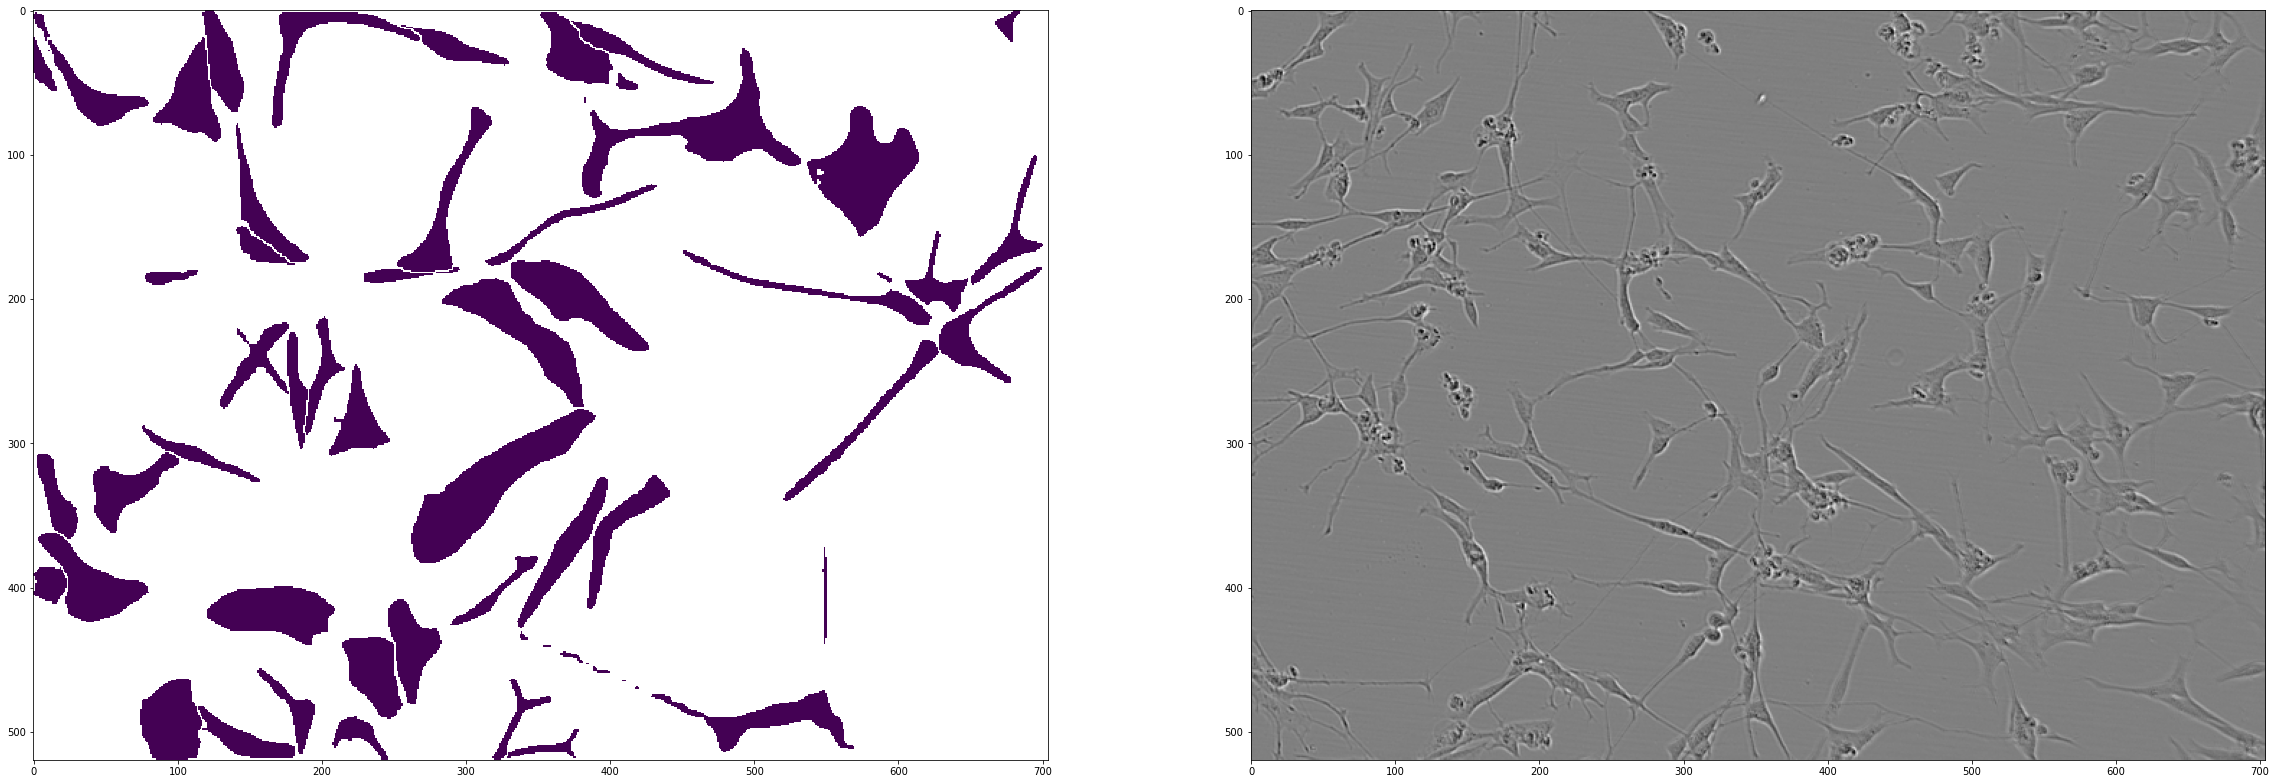

In [10]:
encoded_masks = get_masks(test_names[1], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

In [11]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [12]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,26628 14 27329 18 28031 20 28733 22 29435 24 3...
1,7ae19de7bc2a,146708 6 147412 10 148116 12 148820 14 149524 ...
2,7ae19de7bc2a,148931 6 149633 9 150336 11 151039 13 151742 1...
3,7ae19de7bc2a,126038 6 126739 10 127438 16 128135 23 128839 ...
4,7ae19de7bc2a,179602 3 180305 5 181008 6 181711 7 182414 9 1...
